In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc

In [147]:
chart_color = 'blue'

In [148]:
def get_data_from_db():
    SERVER_NAME = '(localdb)\\Local'
    DATABASE_NAME = 'JobOffers'

    CONNECTION_STRING = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;"

    conn = pyodbc.connect(CONNECTION_STRING)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM Offers")
    data = cursor.fetchall()

    cursor.close()
    conn.close()

    return data

records = get_data_from_db()
df = pd.DataFrame.from_records(records)

In [149]:
df.columns = ['ID', 'Name', 'SalaryFrom', 'ExpLevel', 'OfferPortalCompanyId', 'Category',
              'JobLanguage', 'Location', 'IsRemote', 'Technology', 'ExternalId', 'SalaryTo', 'Company']
df['MidSalary'] = df.apply(lambda row: float((row['SalaryFrom'] + row['SalaryTo']) / 2), axis=1)

df = df.drop(columns=['ExternalId'])

In [150]:
print(df.head())
print(df.describe())

    ID             Name  SalaryFrom ExpLevel  OfferPortalCompanyId   
0  123             ITDS  16800.0000   Senior                     2  \
1  124               7N  25200.0000   Senior                     2   
2  125      Ework Group  18480.0000   Senior                     2   
3  126         ROCKWOOL      0.0000      Mid                     2   
4  127  Omni Calculator   7300.0000      Mid                     2   

          Category JobLanguage  Location  IsRemote Technology    SalaryTo   
0             data              Warszawa     False       None  25200.0000  \
1  businessAnalyst          en  Warszawa     False       None  28560.0000   
2              erp                Kraków     False       None  29400.0000   
3          support                Poznan     False       None      0.0000   
4        marketing                Remote      True              9600.0000   

           Company  MidSalary  
0             ITDS    21000.0  
1               7N    26880.0  
2      Ework Group  

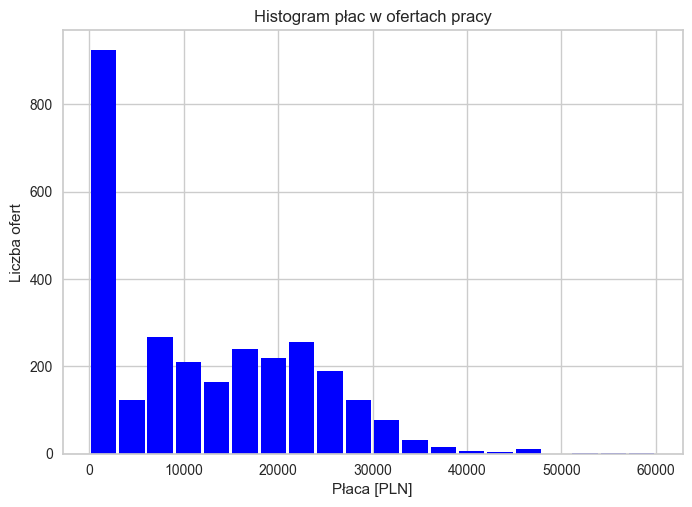

In [151]:
plt.hist(df['MidSalary'], bins=20, rwidth=0.9, color=chart_color)
plt.xlabel('Płaca [PLN]')
plt.ylabel('Liczba ofert')
plt.title('Histogram płac w ofertach pracy')
plt.show()

Z histogramu płac w ofertach pracy wynika, że najwięcej ofert pracy dotyczy płac w przedziale od 0 do 5000 PLN.
Są to jednak dane niewiarygodne, gdyż bardzo wiele ofert nie podaje widełek wynagrodzenia.
Jest to zjawisko negatywnie wpływające na jakość danych. W celu przewidzenia wynagrodzenia na podstawie pewnych cech, nie powinniśmy 
brać pod uwagę ofert, które nie podają widełek wynagrodzenia, ponieważ zaburzy nam drastycznie wyniki modelu.

In [152]:
df = df[df['MidSalary'] > 0]

Po usunięciu ofert, które nie podają widełek wynagrodzenia, zobaczmy jak wygląda histogram płac w ofertach pracy.

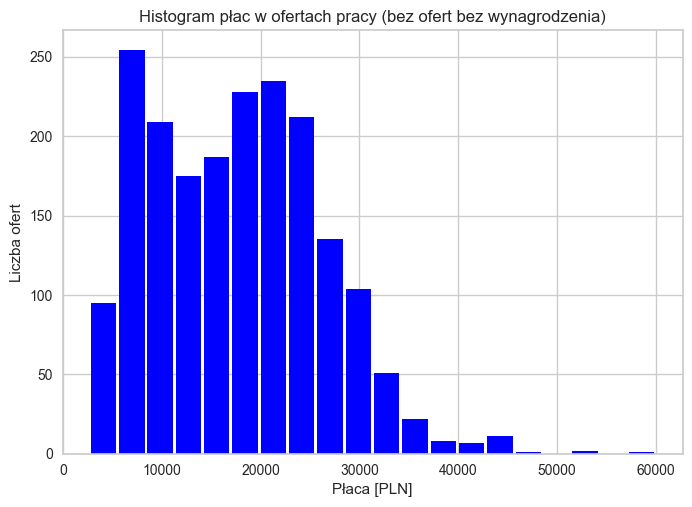

In [153]:
plt.hist(df['MidSalary'], bins=20, rwidth=0.9, color=chart_color)
plt.xlabel('Płaca [PLN]')
plt.ylabel('Liczba ofert')
plt.title('Histogram płac w ofertach pracy (bez ofert bez wynagrodzenia)')
plt.show()

In [154]:
print(df['MidSalary'].describe())
print('Median: ', df['MidSalary'].median())


count     1937.000000
mean     17637.343314
std       8578.942630
min       2664.000000
25%      10000.000000
50%      17500.000000
75%      23520.000000
max      60000.000000
Name: MidSalary, dtype: float64
Median:  17500.0


Location
Remote           631
Warszawa         520
Kraków           194
Wroclaw          100
Other             87
Gdansk            69
Poznan            60
Katowice          53
Abroad            38
Łódź              34
Gliwice           25
Rzeszów           21
Gdynia            20
Szczecin          13
Lublin            10
Bialystok         10
Bydgoszcz          9
Zielona Góra       9
Chorzów            7
Zabierzów          7
Adamów             6
Torun              5
Bielsko-Biala      5
Tychy              3
Opole              1
dtype: int64


<BarContainer object of 25 artists>

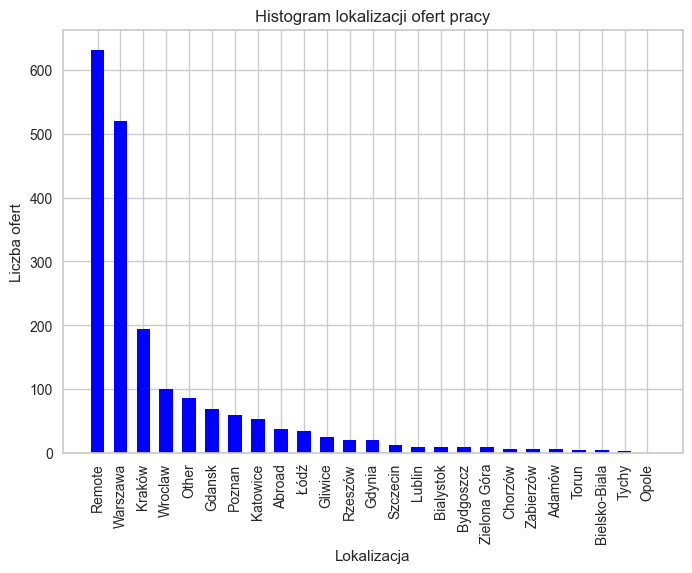

In [155]:
locations = df.groupby('Location').size().sort_values(ascending=False)

print(locations)

plt.title('Histogram lokalizacji ofert pracy')
plt.xlabel('Lokalizacja')
plt.ylabel('Liczba ofert')

# rotate x labels
plt.xticks(rotation=90)
# bar but horizontal
plt.bar(locations.index, locations.values, color='blue', width=0.6)

In [172]:
remote_to_all_proportion = df['Location'].where(df['Location'] == 'Remote').count() / df['Location'].count()

print(f'Procent ofert prac zdalnych: {remote_to_all_proportion * 100:.2f}%')

Procent ofert prac zdalnych: 32.58%


In [173]:
abroad_to_all_proportion = df['Location'].where(df['Location'] == 'Abroad').count() / df['Location'].count()

print(f'Procent ofert pracy za granicą: {abroad_to_all_proportion * 100:.2f}%')

Procent ofert pracy za granicą: 1.96%


Z opisu statystycznego wynagrodzeń w ofertach pracy wynika, że:
- średnie wynagrodzenie wynosi 17637 PLN
- mediana wynagrodzeń wynosi 17500 PLN
- minimalne wynagrodzenie wynosi 2664 PLN

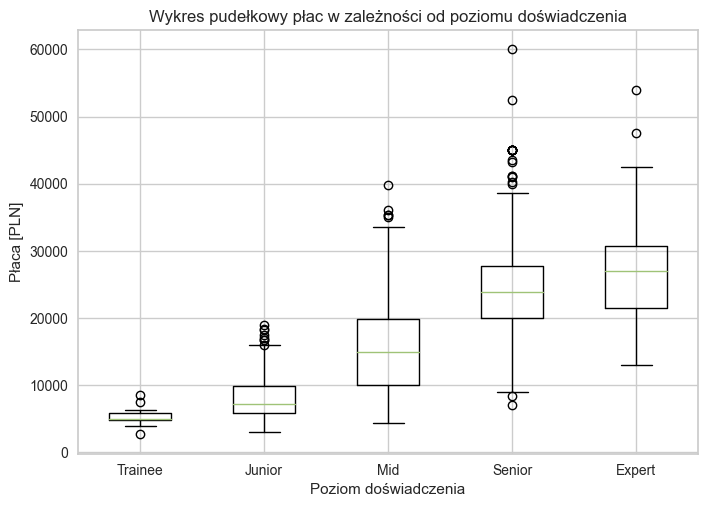

In [156]:
exp_levels = df['ExpLevel'].unique()

mean_salaries = df.groupby('ExpLevel')['MidSalary'].mean()

sorted_exp_levels = mean_salaries.sort_values().index

data = [df[df['ExpLevel'] == exp_level]['MidSalary'] for exp_level in sorted_exp_levels]

plt.boxplot(data, labels=sorted_exp_levels)

plt.title('Wykres pudełkowy płac w zależności od poziomu doświadczenia')
plt.suptitle('')
plt.xlabel('Poziom doświadczenia')
plt.ylabel('Płaca [PLN]')
plt.show()

In [157]:
# get avg salary for each exp level
mean_salaries.sort_values(ascending=False, inplace=True)
mean_salaries

ExpLevel
Expert     26890.650602
Senior     24242.493808
Mid        15429.122905
Junior      8154.893617
Trainee     5232.709677
Name: MidSalary, dtype: float64

## Im wyższy poziom doświadczenia, tym wyższe wynagrodzenie.
Z wykresu pudełkowego wyraźnie widać, że poziom doświadczenia ma zdecydowany wpływ na wynagrodzenie.

In [158]:
# analyze salary by category
categories = df['Category'].unique()
categories

array(['data', 'businessAnalyst', 'erp', 'marketing', 'backend',
       'fullstack', 'architecture', 'ux', 'other', 'sales', 'testing',
       'electronics', 'devops', 'embedded', 'frontend',
       'sysAdministrator', 'projectManager', 'security', 'support',
       'robotics', 'automation', 'productManagement', 'customerService',
       'finance', 'officeAdministration', 'logistics',
       'businessIntelligence', 'consulting', 'mobile',
       'artificialIntelligence', 'agile', 'gameDev', 'telecommunication',
       'hr', 'law', None], dtype=object)

In [159]:
mean_salaries = df.groupby('Category')['MidSalary'].mean()
sorted_categories = mean_salaries.sort_values().index

data = [df[df['Category'] == category]['MidSalary'] for category in sorted_categories]

category_salaries = pd.DataFrame(mean_salaries)
category_salaries = category_salaries.sort_values(by='MidSalary', ascending=False)

category_salaries

,MidSalary
Category,
artificialIntelligence,27135.552632
architecture,25766.500000
data,23632.850394
agile,22725.000000
backend,21734.632479
businessIntelligence,21438.657895
mobile,21292.260000
gameDev,21287.250000
security,21256.121622


Z analizy wynagrodzeń w zależności od kategorii (specjalizacji) ofert wynika, że największe zarobki są w kategorii
- Sztuczna inteligencja - 27100 PLN
- Architekt kodu - 25800 PLN
- Analiza danych - 23600 PLN
- Agile / Scrum - 22700 PLN
- Backend - 21700 PLN

In [160]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def generate_model(df, dest, categorical_features, numerical_features):
    X = df[categorical_features + numerical_features]
    y = df[dest]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    transformers = [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
    
    if len(numerical_features) > 0:
        transformers.append(('num', 'passthrough', numerical_features))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print('Score: ', model.score(X_test, y_test))
    print('Mean squared error: ', np.mean((y_pred - y_test) ** 2))
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.3, color=chart_color)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Wartość przewidziana')
    plt.title('Porównanie wartości rzeczywistych i przewidzianych')
    plt.show()
    
    return model, X_train, X_test, y_train, y_test

Score:  0.7372308944518545
Mean squared error:  19866595.725729212


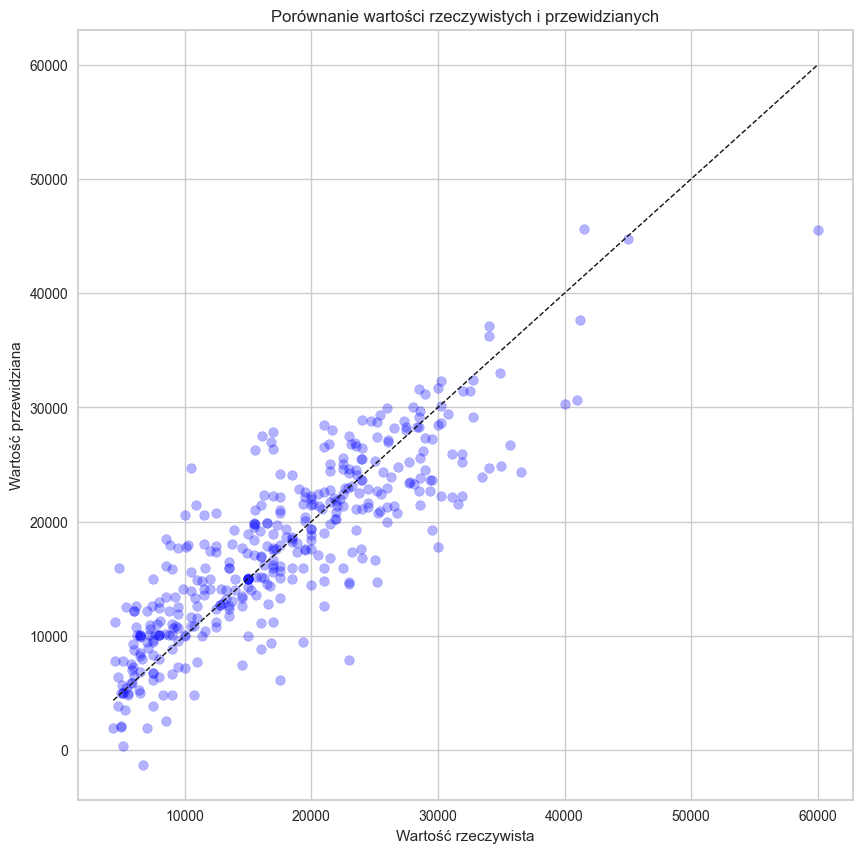

(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ExpLevel', 'Technology',
                                                    'Category', 'Company']),
                                                  ('num', 'passthrough',
                                                   ['IsRemote'])])),
                 ('regressor', LinearRegression())]),
      ExpLevel Technology           Category              Company  IsRemote
 1476   Junior       None        electronics           SILVERHAND     False
 1130   Expert      Azure       architecture       Avanade Poland     False
 207    Senior        AWS           security             MANGOPAY      True
 1074      Mid       None              sales   adShock Sp. z o.o.      True
 290       Mid       None  telecommunication             AVSystem     False
 ...      

In [161]:
generate_model(df, ['MidSalary'], ['ExpLevel', 'Technology', 'Category', 'Company'], ['IsRemote'])

In [162]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Średni wynik R^2: {np.mean(cv_scores)}")

Średni wynik R^2: 0.6450154991090221


Score:  0.7389427476298331
Mean squared error:  19737171.47336985


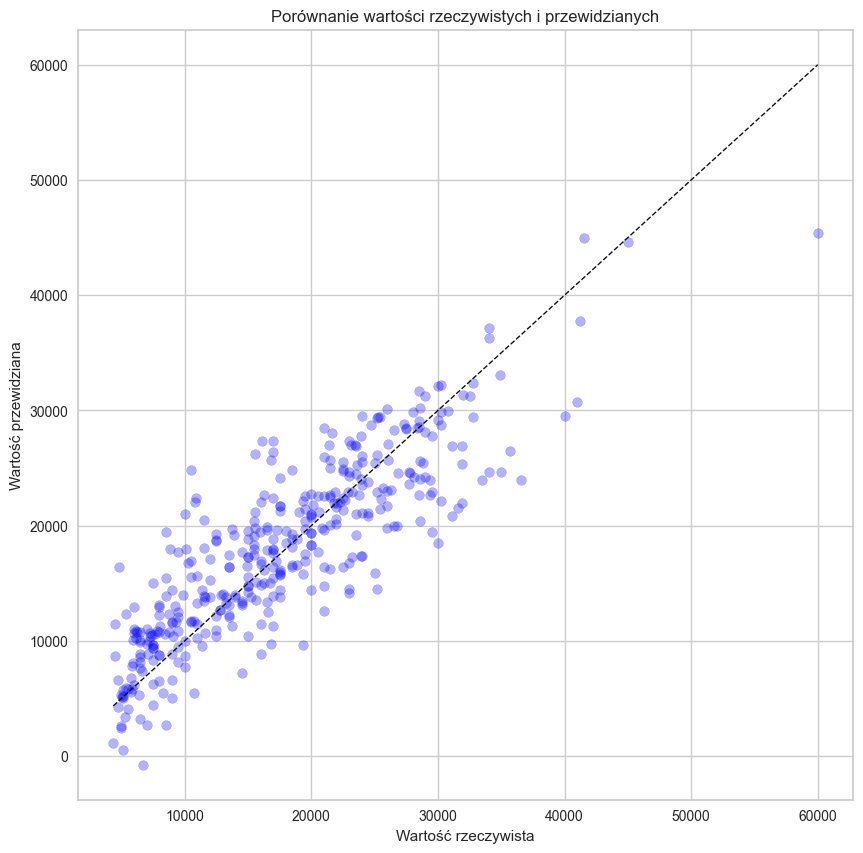

In [163]:
model, X_train, X_test, y_train, y_test = generate_model(df, 
               dest=['MidSalary'], 
               categorical_features=['ExpLevel', 'Category', 'Company', 'Technology', 'Location'], 
               numerical_features=['IsRemote'])

Zobaczmy jakie cechy mają największy wpływ na wynagrodzenie.

In [164]:
importance = np.reshape(model.named_steps['regressor'].coef_, (-1, 1))[:-1]
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_importance = pd.DataFrame(importance, index=feature_names, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.head(20)


,Importance
Company_Snowflake,23646.257286
Company_Technosource,17071.146122
Company_KZ INSPIRE,16624.707714
Company_Chorus One,15690.840583
Company_Infopulse,15651.570545
Company_Plenti,14813.497044
Company_Harvey Nash Technology Sp. z o.o.,14320.100393
Company_RunBit,12440.591520
Company_vonRoll Infratec.com,12315.745869
Company_Be in IT,12208.099371


Z analizy cech wynika, że największy wpływ na wynagrodzenie ma wybór firmy.
Nie uważam, żeby to była dobra cecha, ponieważ chcemy przewidzieć wynagrodzenie na podstawie ogólnych cech, a nie na podstawie firmy.
Firma może chcieć zatrudniać wyłącznie najlepszych specjalistów, co wpłynie na wysokie wynagrodzenie.

Usuńmy z listy cechy związane z firmą, gdyż chcemy zobaczyć bardziej ogólne cechy, które wpływają na wynagrodzenie.

In [165]:
feature_importance[~feature_importance.index.str.contains('Company')].head(20)

,Importance
ExpLevel_Expert,9802.318536
Location_Abroad,8764.839137
Technology_Pentesting,8680.042295
Technology_CI/CD,8624.905514
Technology_Android,7992.385182
Technology_iOS,7205.093105
Technology_React native,7102.482831
Technology_ORACLE,6280.745766
Technology_BeyondTrust,6213.839833
Category_businessIntelligence,5867.843906


In [166]:
feature_list = ['Company', 'ExpLevel', 'Category', 'Location', 'Technology']

for feature in feature_list:
    print(feature)
    print(feature_importance[feature_importance.index.str.startswith(feature)].head(20))

Company
                                             Importance
Company_Snowflake                          23646.257286
Company_Technosource                       17071.146122
Company_KZ INSPIRE                         16624.707714
Company_Chorus One                         15690.840583
Company_Infopulse                          15651.570545
Company_Plenti                             14813.497044
Company_Harvey Nash Technology Sp. z o.o.  14320.100393
Company_RunBit                             12440.591520
Company_vonRoll Infratec.com               12315.745869
Company_Be in IT                           12208.099371
Company_Transition Technologies PSC S.A.   11571.509227
Company_Directio Sp. z o.o.                11391.508753
Company_First Derivative                   11139.730390
Company_Varwise                            10754.247525
Company_Wipro IT Services                  10427.296886
Company_int2code GmbH                      10255.815479
Company_Consult Red                     

In [167]:
questions = [
    {
        'ExpLevel': 'Junior',
        'Category': 'IT',
        'Company': 'Xebia',
        'JobLanguage': 'en',
        'Technology': 'Python',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Mid',
        'Category': 'IT',
        'Company': 'Snowflake',
        'JobLanguage': 'pl',
        'Technology': 'Python',
        'IsRemote': 1
    },
]

for question in questions:
    print(question)
    print(model.predict(pd.DataFrame([question])))

{'ExpLevel': 'Junior', 'Category': 'IT', 'Company': 'Xebia', 'JobLanguage': 'en', 'Technology': 'Python', 'IsRemote': 1}


KeyError: "['Location'] not in index"